<a href="https://colab.research.google.com/github/mustafabozkaya/Generative_AI/blob/master/Notebooks/Basic_GAN_Generative_A_I_course_by_Ideami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Generative A.I course by Javier Ideami
# Basic GAN Notebook

# Read a fun article about GANS that I wrote in medium:
# https://towardsdatascience.com/leonardo-and-the-gan-dream-f69e8553e0af?sk=c1fdf85e94c48acd61df451babc41dfe

# import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
# visualization function
def show(tensor, ch=1, size=(28,28), num=16):
  # tensor: 128 x 784
  data=tensor.detach().cpu().view(-1,ch,*size) # 128 x 1 x 28 x 28
  grid = make_grid(data[:num], nrow=4).permute(1,2,0)   # 1 x 28 x 28  = 28 x 28 x 1
  plt.imshow(grid)
  plt.show()


In [3]:
# setup of the main parameters and hyperparameters
epochs = 500
cur_step = 0
info_step = 300
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

bs = 128
device = 'cuda'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),shuffle=True, batch_size=bs)

# number of steps = 60000 / 128 = 468.75

100%|██████████| 9912422/9912422 [00:00<00:00, 404755848.48it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 122112594.58it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 172062780.43it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6887392.90it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
# declare our models

# Generator
def genBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self, z_dim=64, i_dim=784, h_dim=128):
    super().__init__()
    self.gen = nn.Sequential(
        genBlock(z_dim, h_dim), # 64, 128
        genBlock(h_dim, h_dim*2), # 128, 256
        genBlock(h_dim*2, h_dim*4), # 256 x 512
        genBlock(h_dim*4, h_dim*8), # 512, 1024
        nn.Linear(h_dim*8, i_dim), # 1024, 784 (28x28)
        nn.Sigmoid(),
    )

  def forward(self, noise):
       return self.gen(noise)

def gen_noise(number, z_dim):
  return torch.randn(number, z_dim).to(device)

## Discriminator
def discBlock(inp, out):
  return nn.Sequential(
      nn.Linear(inp, out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self, i_dim=784, h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim, h_dim*4), # 784, 1024
        discBlock(h_dim*4, h_dim*2), # 1024, 512
        discBlock(h_dim*2, h_dim), # 512, 256
        nn.Linear(h_dim, 1) # 256, 1
    )

  def forward(self, image):
      return self.disc(image)

In [5]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [6]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [7]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([4, 7, 6, 8, 3, 4, 6, 3, 4, 9])


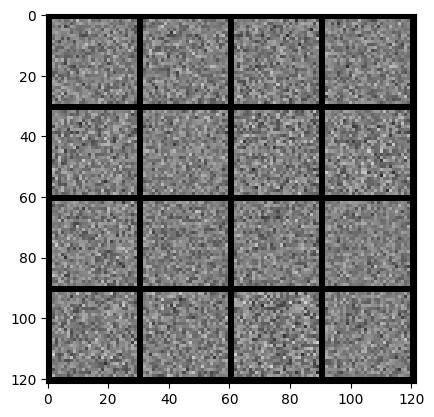

In [8]:
x,y=next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = gen_noise(bs, z_dim)
fake = gen(noise)
show(fake)

In [9]:
# calculating the loss

# generator loss
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   pred = disc(fake)
   targets=torch.ones_like(pred)
   gen_loss=loss_func(pred,targets)

   return gen_loss


def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
   noise = gen_noise(number, z_dim)
   fake = gen(noise)
   disc_fake = disc(fake.detach())
   disc_fake_targets=torch.zeros_like(disc_fake)
   disc_fake_loss=loss_func(disc_fake, disc_fake_targets)

   disc_real = disc(real)
   disc_real_targets=torch.ones_like(disc_real)
   disc_real_loss=loss_func(disc_real, disc_real_targets)

   disc_loss=(disc_fake_loss+disc_real_loss)/2

   return disc_loss




  0%|          | 0/469 [00:00<?, ?it/s]

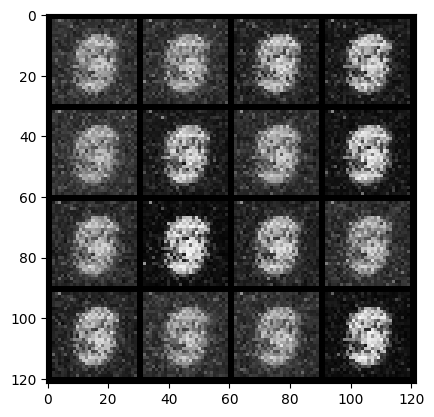

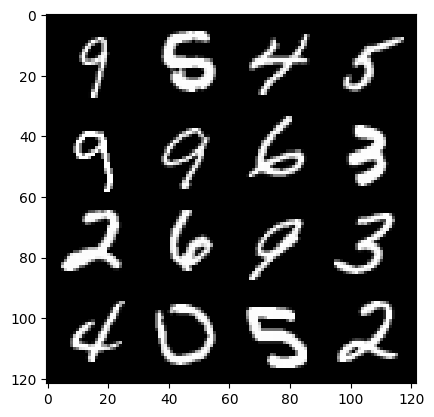

0: step 300 / Gen loss: 1.908842988014221 / disc_loss: 0.33956936287383244


  0%|          | 0/469 [00:00<?, ?it/s]

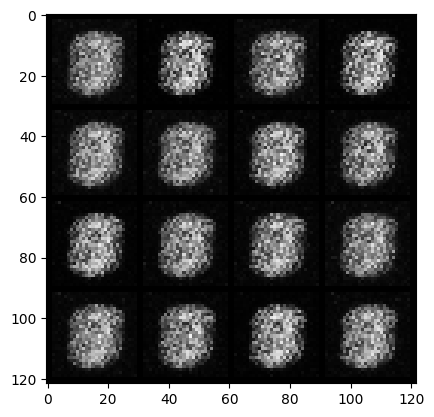

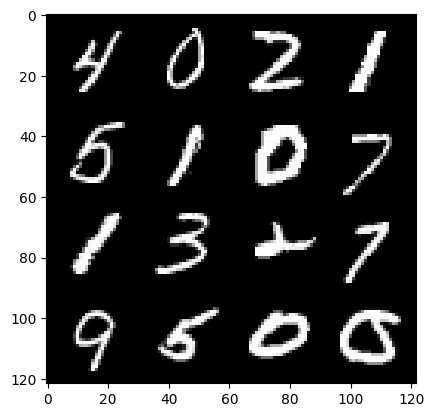

1: step 600 / Gen loss: 3.4473394759496063 / disc_loss: 0.11647303633391866


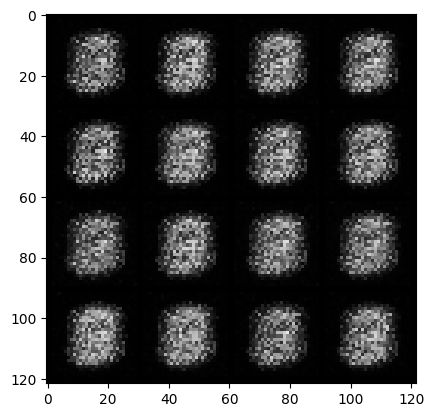

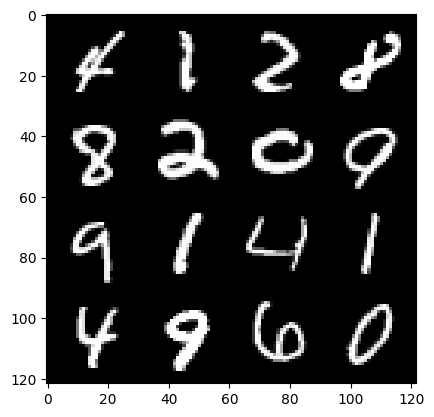

1: step 900 / Gen loss: 3.4616651566823333 / disc_loss: 0.0540355805431803


  0%|          | 0/469 [00:00<?, ?it/s]

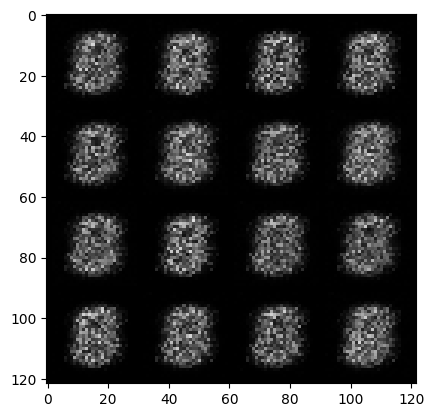

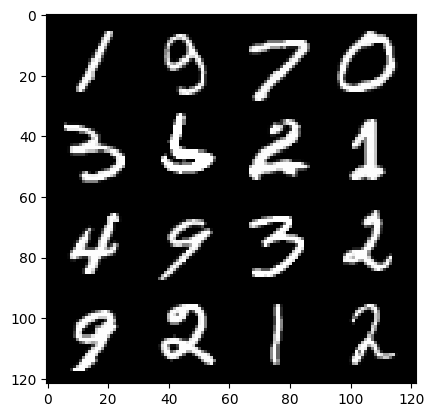

2: step 1200 / Gen loss: 3.6179160237312313 / disc_loss: 0.034111477173864826


  0%|          | 0/469 [00:00<?, ?it/s]

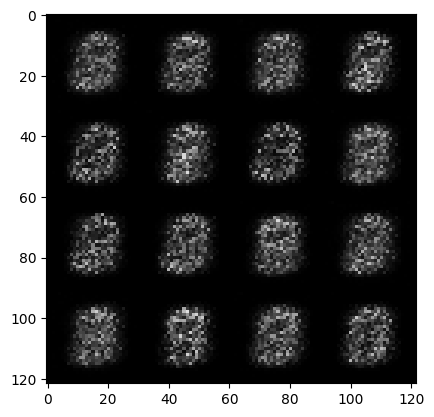

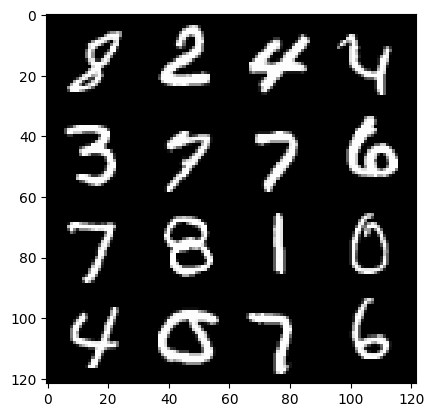

3: step 1500 / Gen loss: 3.4449473508199073 / disc_loss: 0.04034208384032052


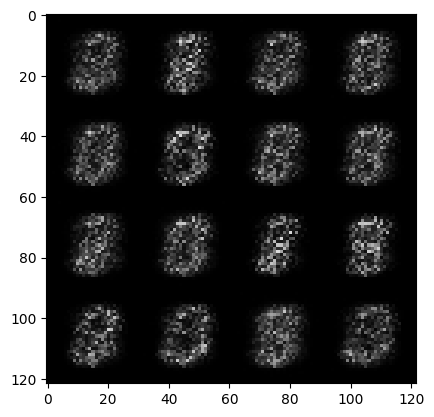

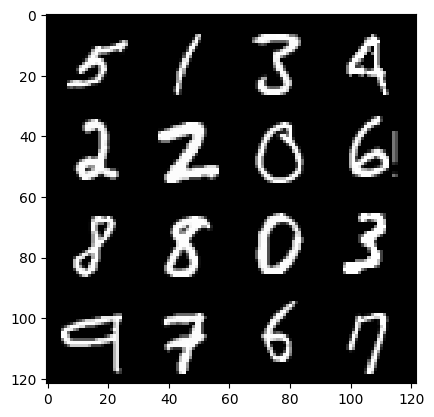

3: step 1800 / Gen loss: 3.3581617689132672 / disc_loss: 0.05150218972315391


  0%|          | 0/469 [00:00<?, ?it/s]

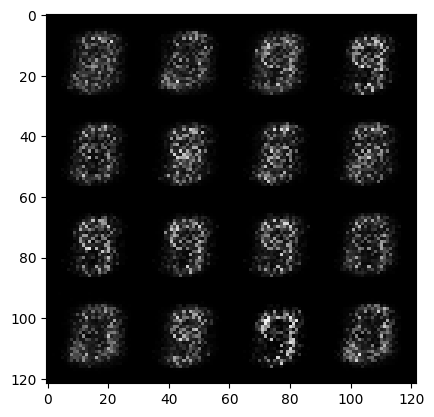

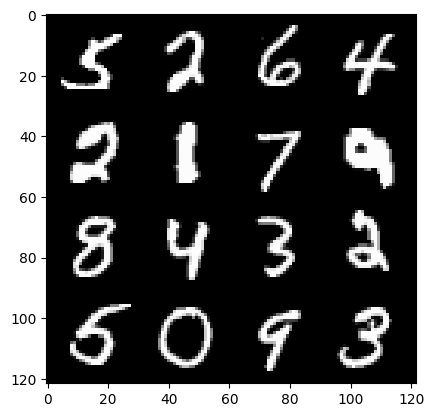

4: step 2100 / Gen loss: 3.419527173042298 / disc_loss: 0.052729338432351724


  0%|          | 0/469 [00:00<?, ?it/s]

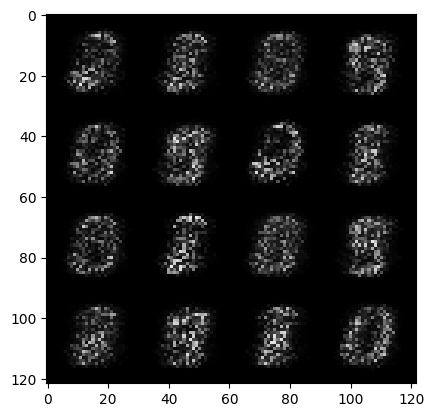

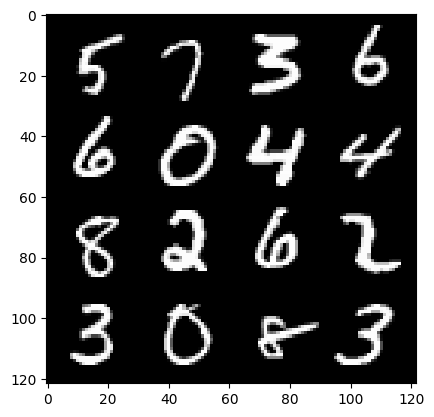

5: step 2400 / Gen loss: 4.065854579607644 / disc_loss: 0.03652530316884319


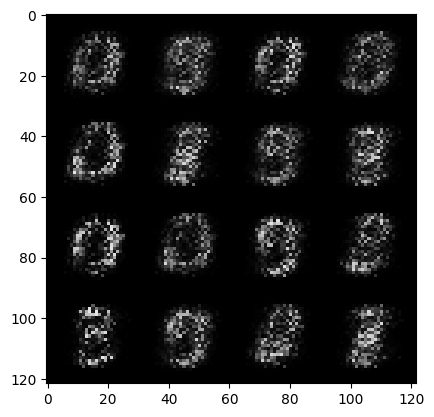

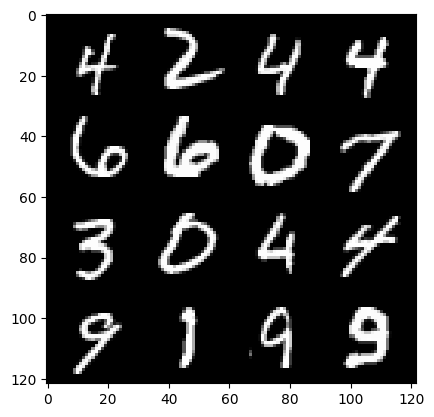

5: step 2700 / Gen loss: 4.441335834662119 / disc_loss: 0.030417999296138695


  0%|          | 0/469 [00:00<?, ?it/s]

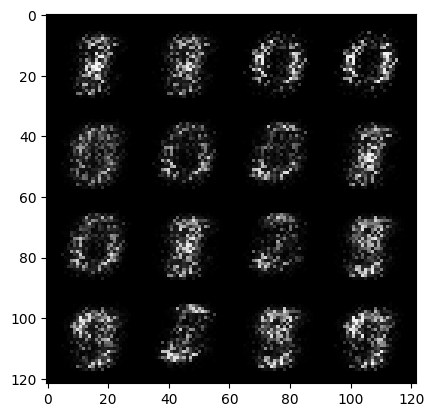

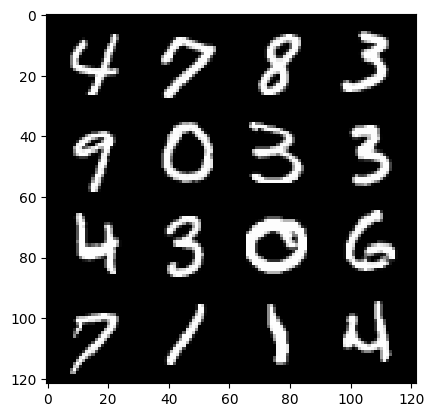

6: step 3000 / Gen loss: 4.485744665463769 / disc_loss: 0.02760661048814653


  0%|          | 0/469 [00:00<?, ?it/s]

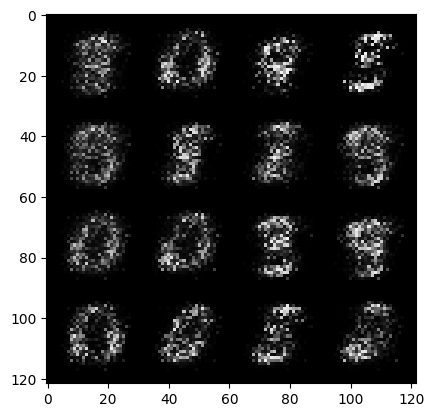

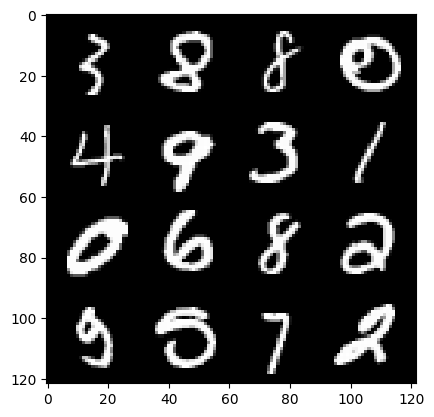

7: step 3300 / Gen loss: 4.8083164707819614 / disc_loss: 0.025183212139333278


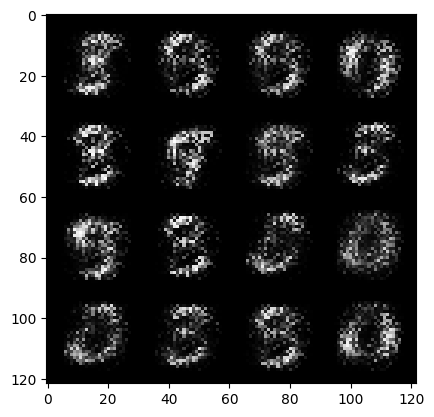

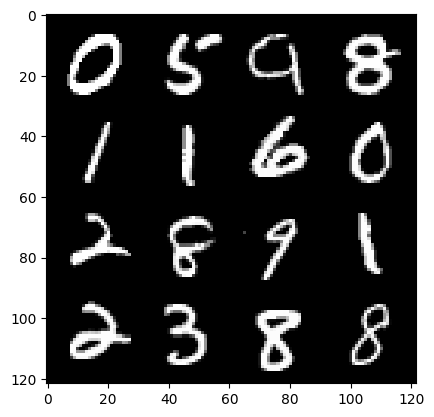

7: step 3600 / Gen loss: 5.21813074588776 / disc_loss: 0.023899172289917867


  0%|          | 0/469 [00:00<?, ?it/s]

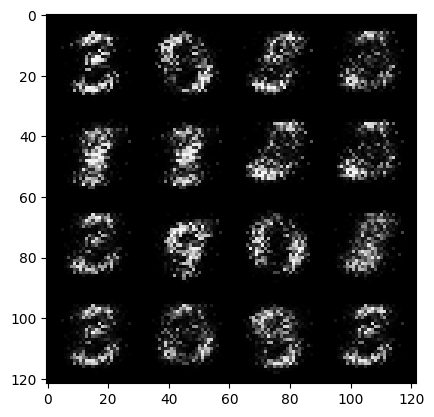

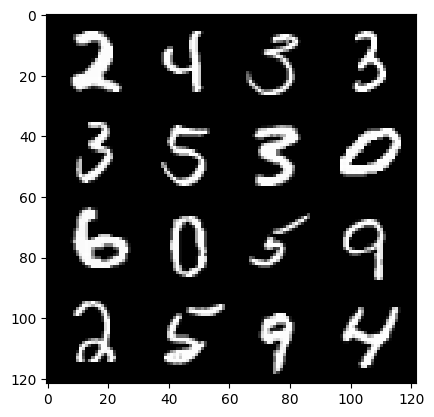

8: step 3900 / Gen loss: 5.549289188385008 / disc_loss: 0.0226848390760521


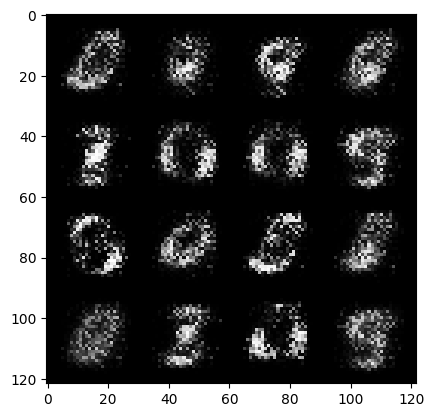

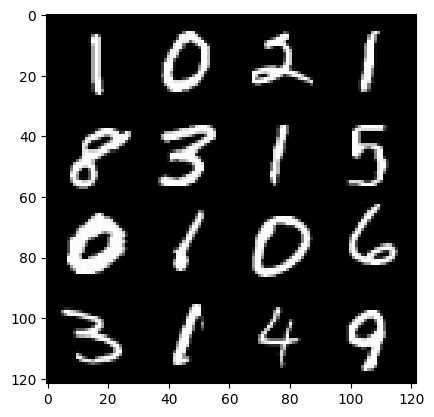

8: step 4200 / Gen loss: 5.710924514134724 / disc_loss: 0.023783625559881325


  0%|          | 0/469 [00:00<?, ?it/s]

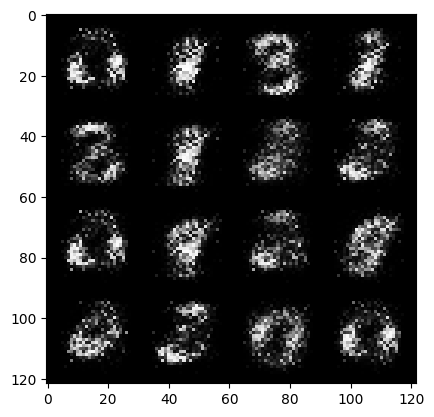

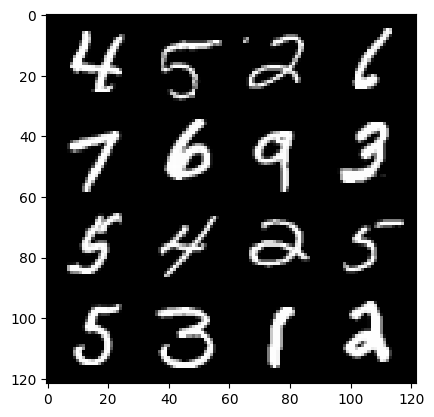

9: step 4500 / Gen loss: 5.5514747412999474 / disc_loss: 0.02172833812423051


  0%|          | 0/469 [00:00<?, ?it/s]

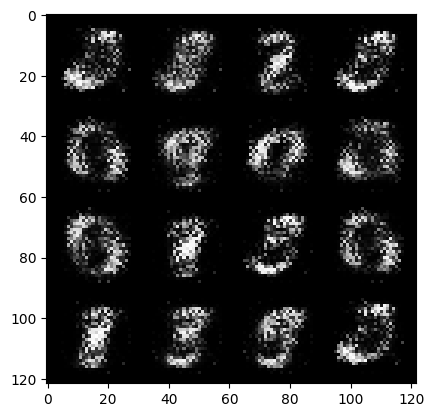

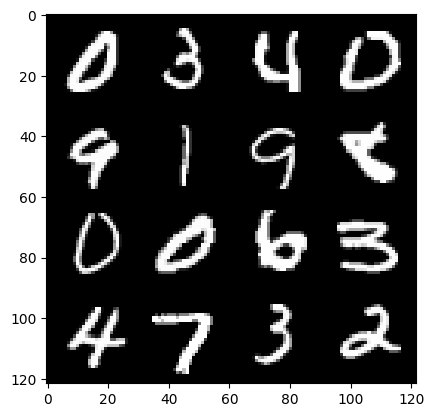

10: step 4800 / Gen loss: 5.810059219996133 / disc_loss: 0.017967031979933386


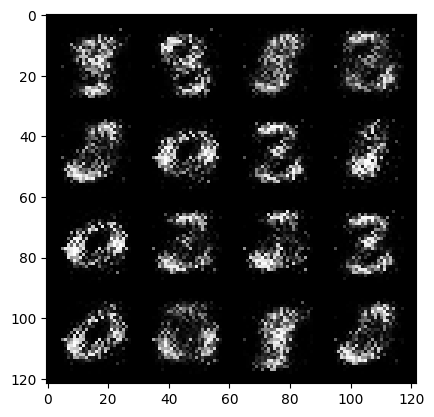

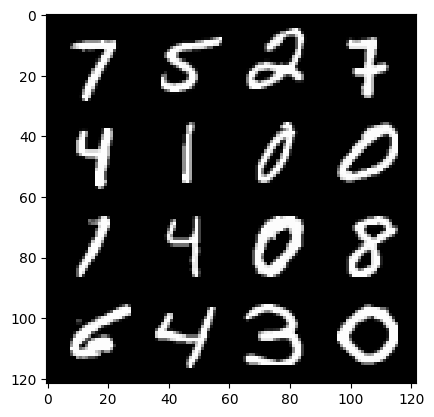

10: step 5100 / Gen loss: 6.077810268402098 / disc_loss: 0.01300319535812984


  0%|          | 0/469 [00:00<?, ?it/s]

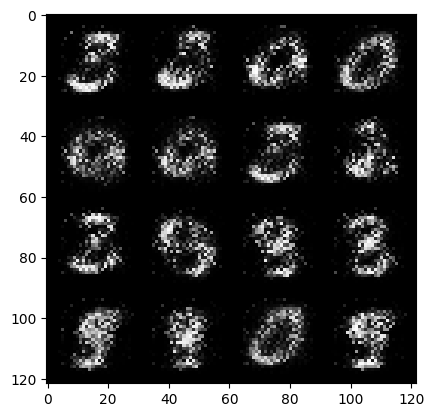

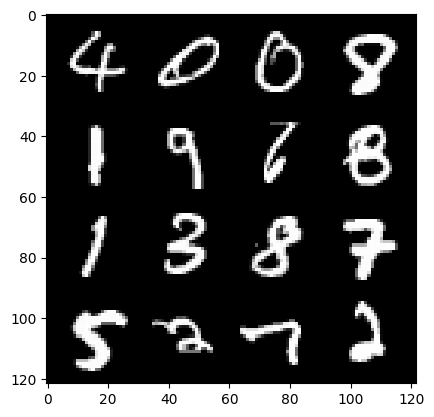

11: step 5400 / Gen loss: 6.310406575202939 / disc_loss: 0.011216344288550333


  0%|          | 0/469 [00:00<?, ?it/s]

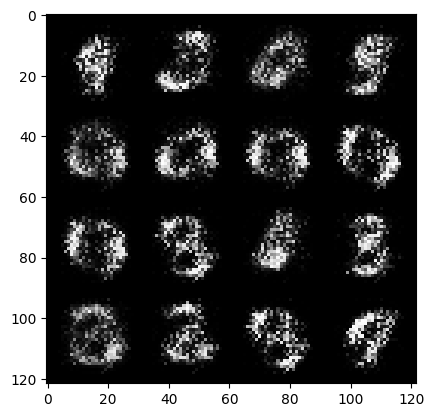

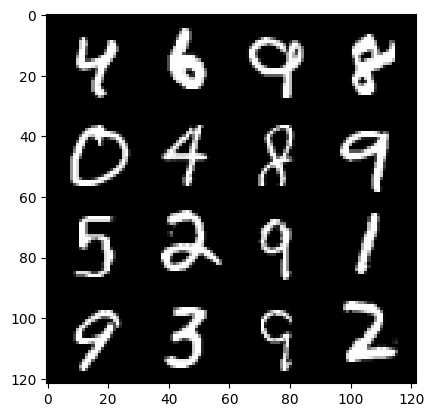

12: step 5700 / Gen loss: 6.743522256215415 / disc_loss: 0.010000436142242213


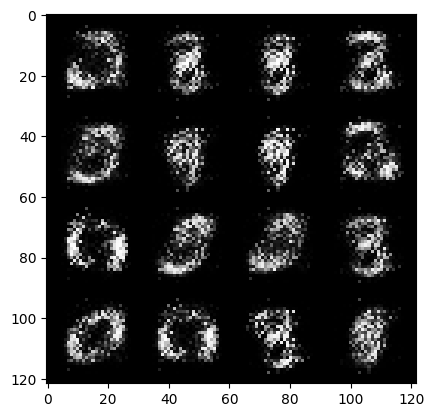

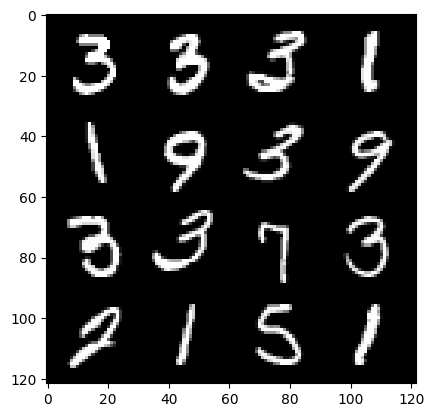

12: step 6000 / Gen loss: 7.000288585027058 / disc_loss: 0.00952944723656401


  0%|          | 0/469 [00:00<?, ?it/s]

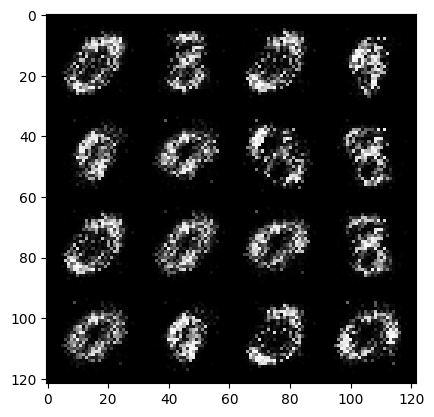

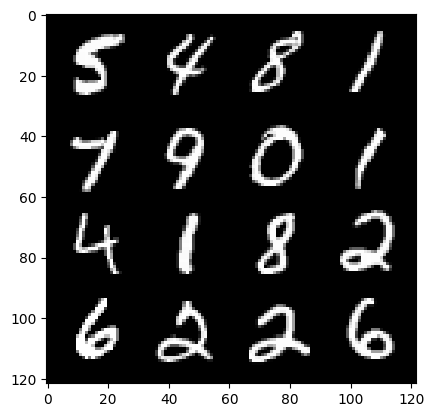

13: step 6300 / Gen loss: 6.6744318421681745 / disc_loss: 0.009675722509467353


  0%|          | 0/469 [00:00<?, ?it/s]

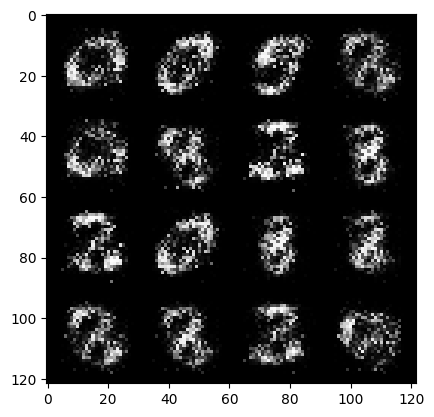

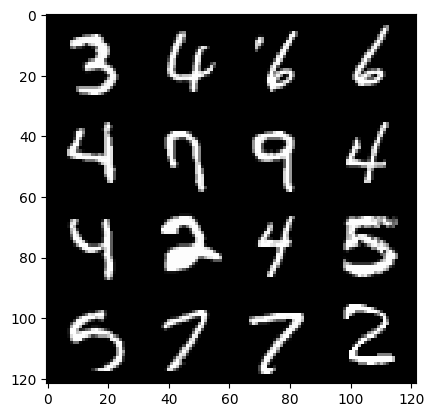

14: step 6600 / Gen loss: 6.935838233629866 / disc_loss: 0.010231258155157165


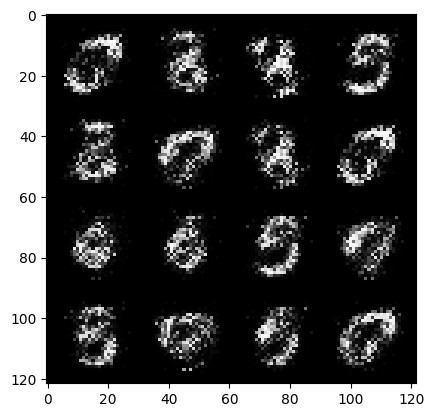

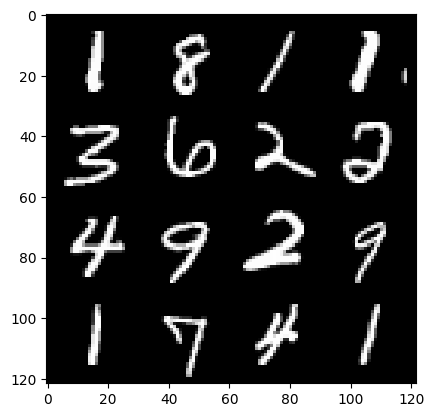

14: step 6900 / Gen loss: 7.328739840189617 / disc_loss: 0.009647754666705918


  0%|          | 0/469 [00:00<?, ?it/s]

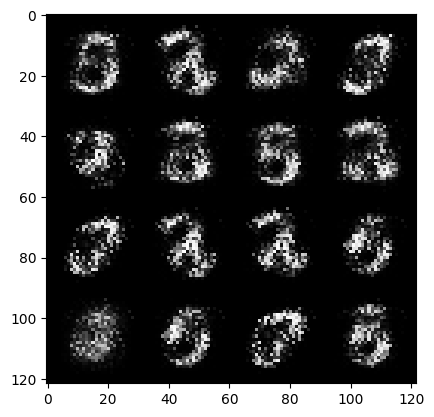

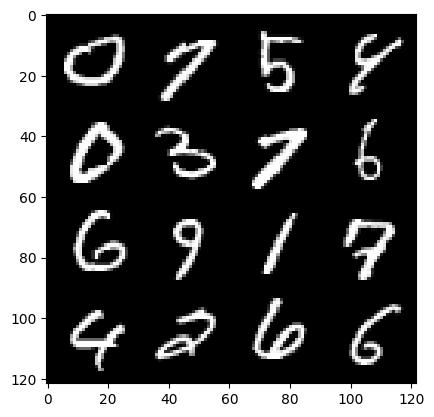

15: step 7200 / Gen loss: 7.030617691675817 / disc_loss: 0.009585765079439935


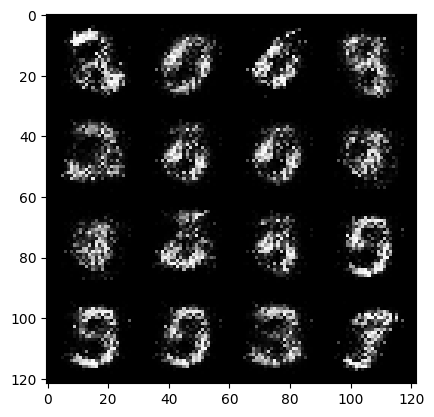

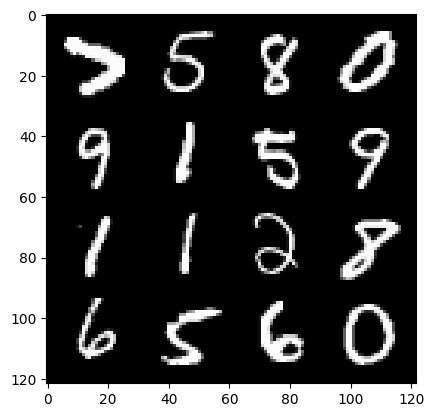

15: step 7500 / Gen loss: 7.17142833073934 / disc_loss: 0.009883100209990515


  0%|          | 0/469 [00:00<?, ?it/s]

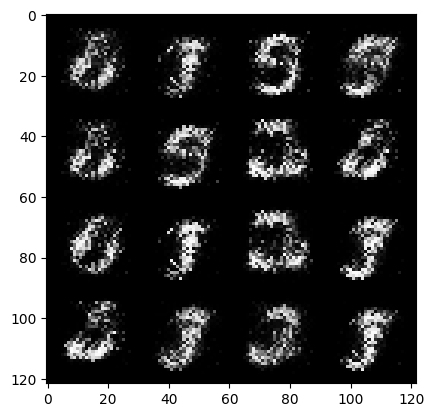

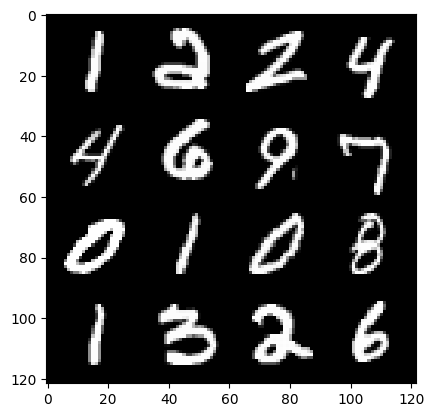

16: step 7800 / Gen loss: 8.102147059440611 / disc_loss: 0.008982026299927384


  0%|          | 0/469 [00:00<?, ?it/s]

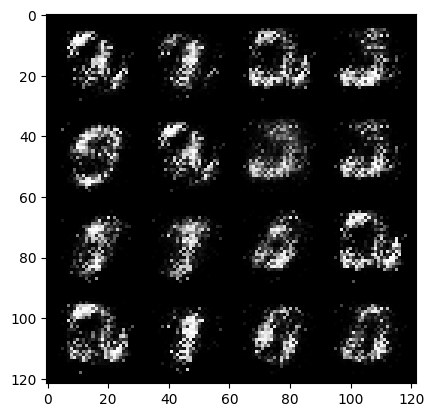

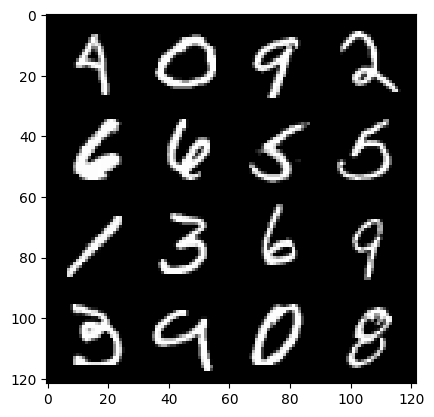

17: step 8100 / Gen loss: 7.398151415189104 / disc_loss: 0.009795990517983839


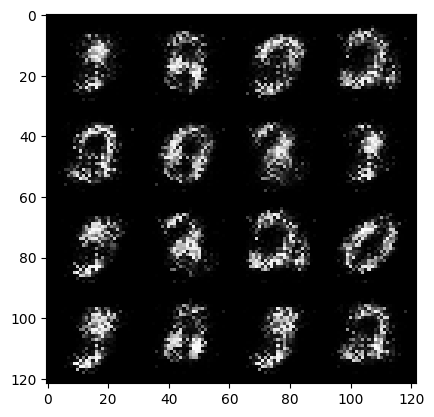

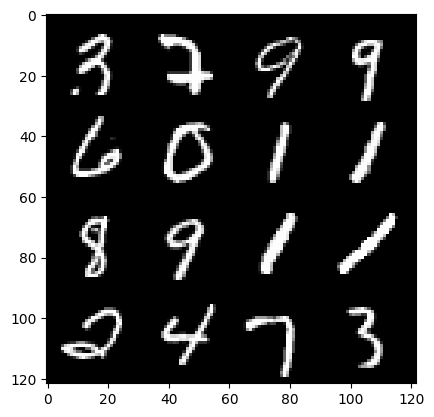

17: step 8400 / Gen loss: 7.972213247617084 / disc_loss: 0.008663139912144594


  0%|          | 0/469 [00:00<?, ?it/s]

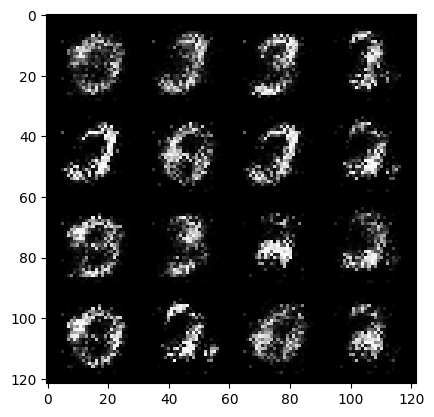

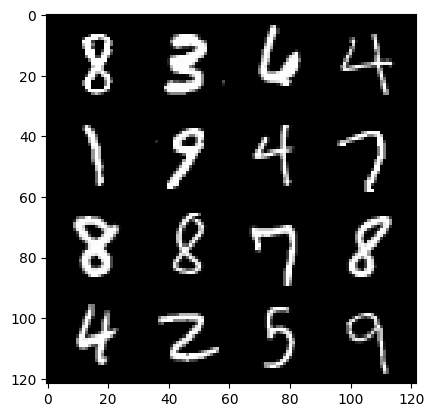

18: step 8700 / Gen loss: 8.019852890968323 / disc_loss: 0.010060154995881027


  0%|          | 0/469 [00:00<?, ?it/s]

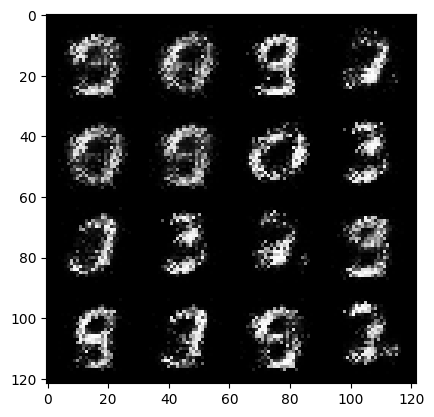

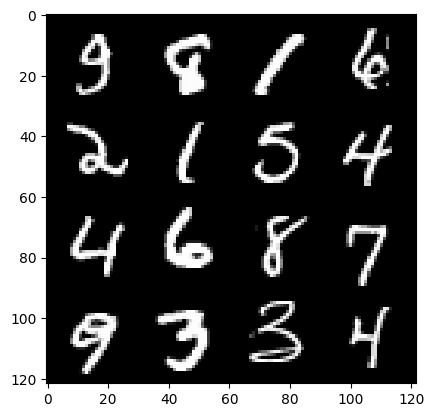

19: step 9000 / Gen loss: 7.852580337524414 / disc_loss: 0.012102338907619322


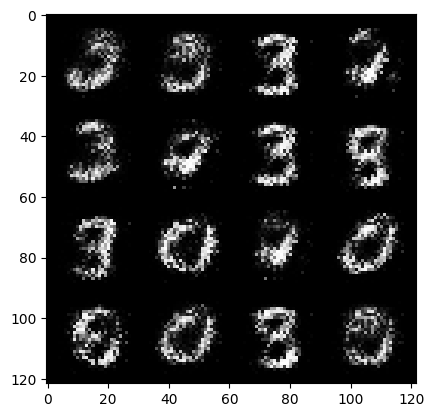

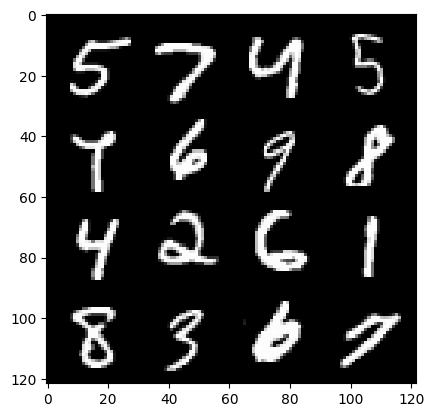

19: step 9300 / Gen loss: 7.152823260625202 / disc_loss: 0.013522311102133247


  0%|          | 0/469 [00:00<?, ?it/s]

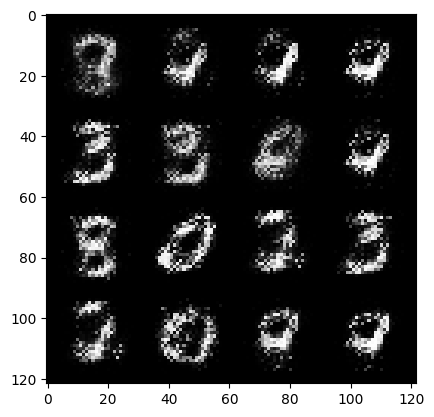

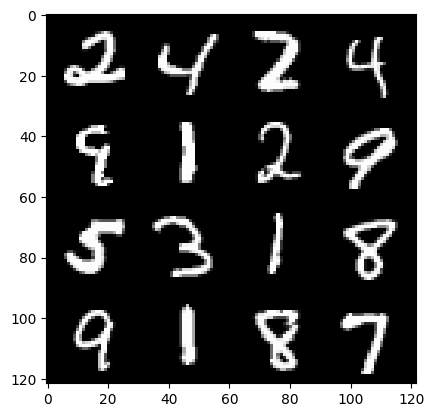

20: step 9600 / Gen loss: 7.089715266227716 / disc_loss: 0.011634712394637365


  0%|          | 0/469 [00:00<?, ?it/s]

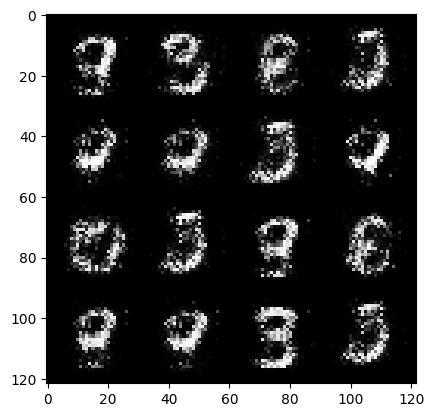

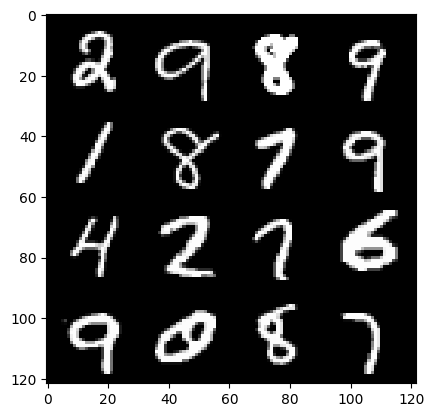

21: step 9900 / Gen loss: 6.946336803436285 / disc_loss: 0.009851213863585135


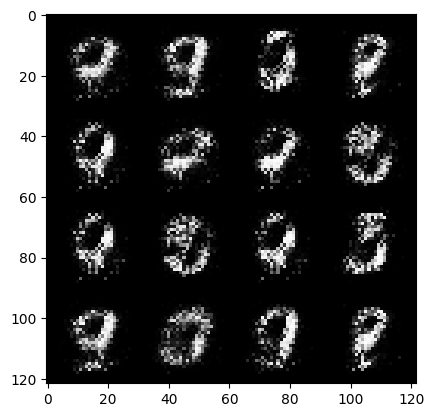

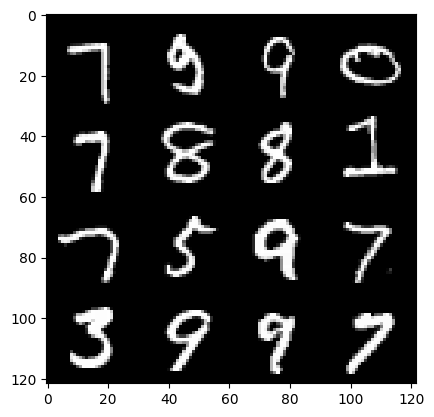

21: step 10200 / Gen loss: 7.003418726921083 / disc_loss: 0.009891418250044802


  0%|          | 0/469 [00:00<?, ?it/s]

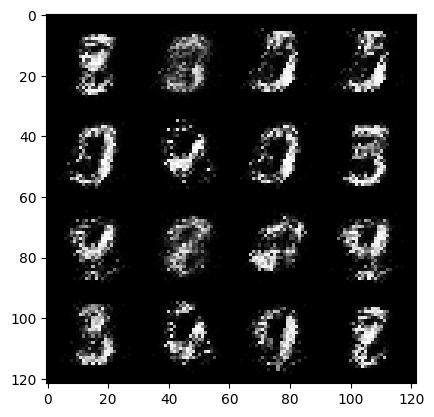

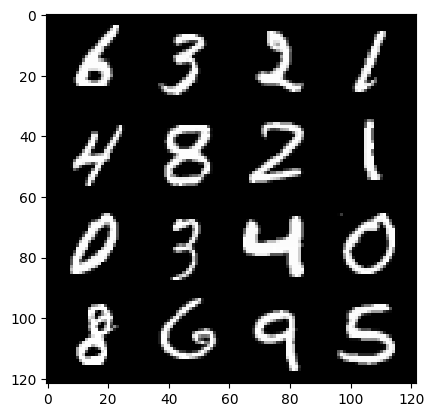

22: step 10500 / Gen loss: 7.172431025505067 / disc_loss: 0.010651097256535043


  0%|          | 0/469 [00:00<?, ?it/s]

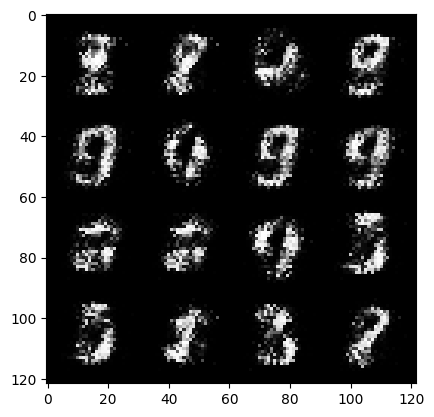

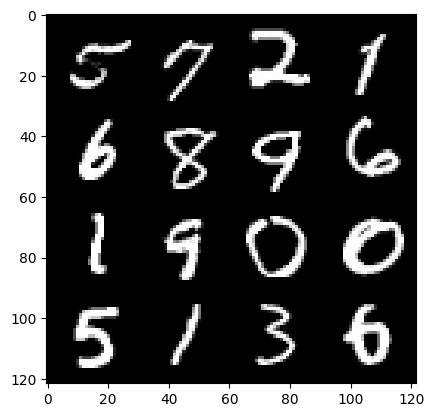

23: step 10800 / Gen loss: 7.004159847895301 / disc_loss: 0.01385652147854368


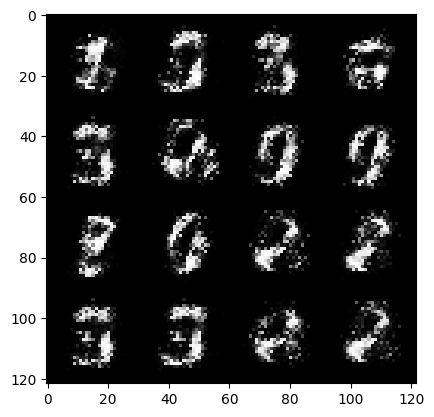

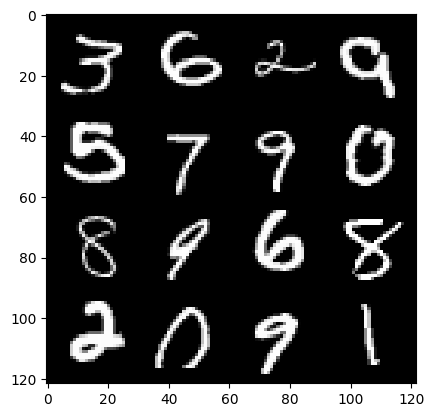

23: step 11100 / Gen loss: 6.800035041173298 / disc_loss: 0.015318546885779752


  0%|          | 0/469 [00:00<?, ?it/s]

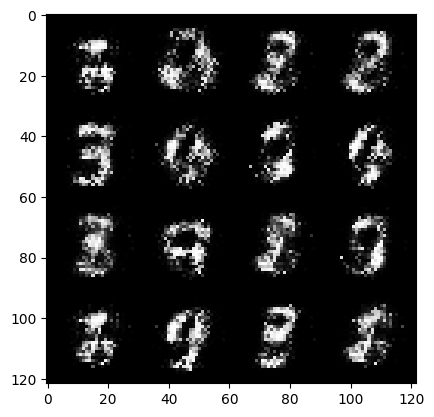

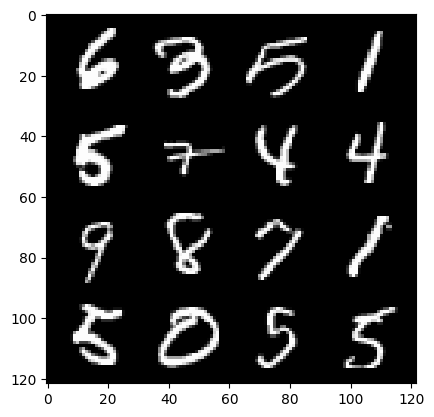

24: step 11400 / Gen loss: 7.275914122263588 / disc_loss: 0.016397858265942564


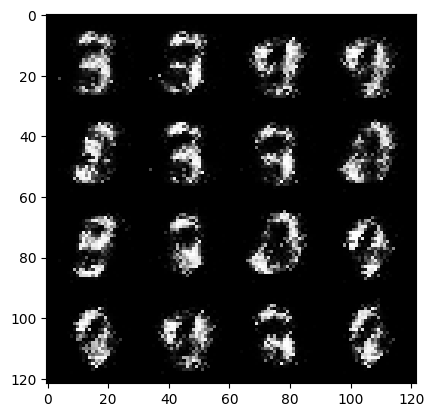

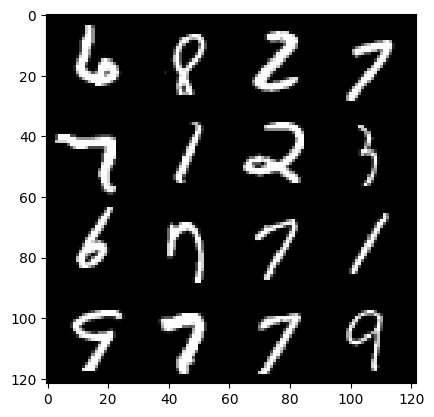

24: step 11700 / Gen loss: 7.239996474583946 / disc_loss: 0.014764850578115638


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [10]:
### 60000 / 128 = 468.75  = 469 steps in each epoch
### Each step is going to process 128 images = size of the batch (except the last step)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_opt.zero_grad()

    cur_bs=len(real) # real: 128 x 1 x 28 x 28
    real = real.view(cur_bs, -1) # 128 x 784
    real = real.to(device)

    disc_loss = calc_disc_loss(loss_func,gen,disc,cur_bs,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_opt.step()

    ### generator
    gen_opt.zero_grad()
    gen_loss = calc_gen_loss(loss_func,gen,disc,cur_bs,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_opt.step()

    ### visualization & stats
    mean_disc_loss+=disc_loss.item()/info_step
    mean_gen_loss+=gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step>0:
      fake_noise = gen_noise(cur_bs, z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step+=1